[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timz815/IAT360-CV-Project/blob/main/CVNotebook.ipynb)

In [1]:
#pip3 install notebook
#pip3 install numpy pandas matplotlib tensorflow opencv-python seaborn pillow

# For local runtime, in cmd/terminal paste: jupyter notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import json
from pathlib import Path
import torch


In [2]:
# =========
# Load Data
# =========

# For MAC
#base_dir = "/Users/tim/Downloads/CV_dataset"

# For Windows
#base_dir = r"C:\Users\timot\Downloads\CV_dataset"
base_dir = r"C:\Users\timot\Documents\dataset_2\dataset_for_training"


ann_dir = os.path.join(base_dir, "ann")
img_dir = os.path.join(base_dir, "img")


# Check if dataset is correct, can comment out
print(f"Dataset Folder found: {os.path.exists(base_dir)}")
print(f"Images found: {sum(len(glob.glob(os.path.join(img_dir, f'*.{ext}'))) for ext in ['png','jpg','jpeg'])}")
print(f"Annotations found: {len(glob.glob(os.path.join(ann_dir, '*.txt')))}")


Dataset Folder found: True
Images found: 5803
Annotations found: 5803


In [3]:
# ===========
# Verify Data
# ===========

# Define base_output_dir first
base_output_dir = os.path.join(base_dir, "Final_Seg_Data")

# Check if dataset is already processed
output_check = glob.glob(os.path.join(base_output_dir, "images/*/*"))
if output_check and len(output_check) > 10:  # If we have at least 10 images
    print("Dataset already processed")

    # Count existing valid pairs from output directories, including test set
    train_images = glob.glob(os.path.join(base_output_dir, "images/train/*"))
    val_images = glob.glob(os.path.join(base_output_dir, "images/val/*"))
    test_images = glob.glob(os.path.join(base_output_dir, "images/test/*"))
    valid_pairs_count = len(train_images) + len(val_images) + len(test_images)

    print(f"Found {valid_pairs_count} valid pairs in existing dataset")

else:
    valid_pairs = []
    image_files = (glob.glob(os.path.join(img_dir, "*.png")) +
                   glob.glob(os.path.join(img_dir, "*.jpg")) +
                   glob.glob(os.path.join(img_dir, "*.jpeg")))

    for image_file in image_files:
        # Strip extension to match cleaned annotation filenames
        image_name = os.path.splitext(os.path.basename(image_file))[0]
        label_file = os.path.join(ann_dir, f"{image_name}.txt")

        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                content = f.read().strip()

            if content:
                valid_pairs.append((image_file, label_file))

    print(f"Found {len(valid_pairs)} valid pairs")


Dataset already processed
Found 5803 valid pairs in existing dataset


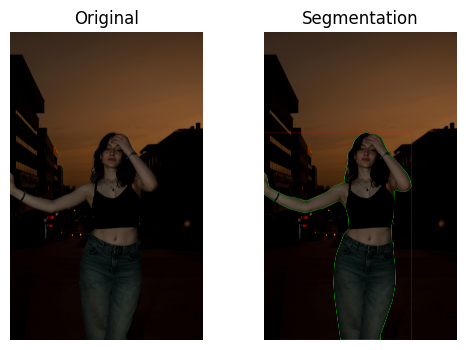

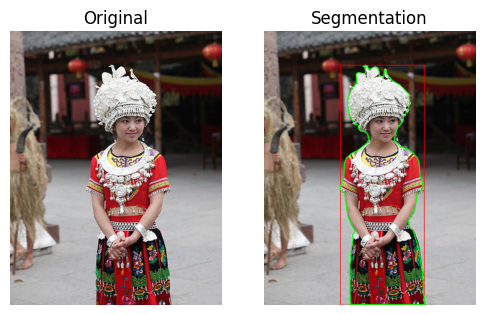

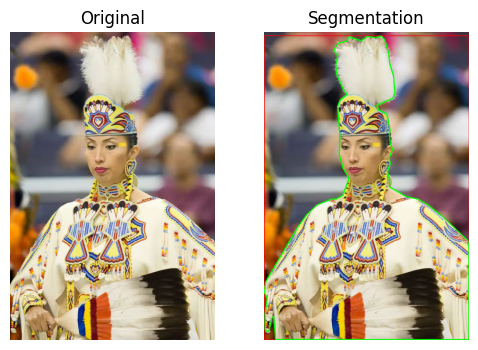

In [4]:
# ===================
# Visualization Check
# ===================

for i in range(min(3, len(valid_pairs))):
    image_path, ann_path = valid_pairs[i]

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    overlay = image.copy()

    with open(ann_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 6:
                # --- Bounding Box ---
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                box_w = float(parts[3]) * width
                box_h = float(parts[4]) * height

                x1 = int(x_center - box_w/2)
                y1 = int(y_center - box_h/2)
                x2 = int(x_center + box_w/2)
                y2 = int(y_center + box_h/2)

                # Red Box
                cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # --- Polygon Mask ---
                polygon_points = []
                for j in range(5, len(parts), 2):
                    if j + 1 < len(parts):
                        x = float(parts[j]) * width
                        y = float(parts[j + 1]) * height
                        polygon_points.append([x, y])

                if len(polygon_points) > 2:
                    pts = np.array(polygon_points, np.int32)
                    # Green Mask
                    cv2.polylines(overlay, [pts], True, (0, 255, 0), 3)

    # Display Config
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Segmentation")
    plt.axis('off')

    # Display
    plt.show()

In [4]:
# ==================
# Create YAML Config
# ==================

yaml_path = os.path.join(base_dir, "segmentation_config.yaml")
yaml_content = f"""
path: {os.path.join(base_dir, "Final_Seg_Data")}
train: images/train
val: images/val
test: images/test

# Number of classes
nc: 1

# Class names
names:
  0: person
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content)


In [5]:
# ===================
# Split and Copy Data
# ===================

import os
import shutil
from math import floor

base_output_dir = os.path.join(base_dir, "Final_Seg_Data")

train_images_dir = os.path.join(base_output_dir, "images/train")
if os.path.exists(train_images_dir) and len(os.listdir(train_images_dir)) > 0:
    print("Dataset already exists! Skipping file copying.")
    print(f"Found {len(os.listdir(train_images_dir))} images in train folder")
else:
    # Create directories for train/val/test
    for folder in ["images/train", "images/val", "images/test",
                   "labels/train", "labels/val", "labels/test"]:
        os.makedirs(os.path.join(base_output_dir, folder), exist_ok=True)

    # Split valid_pairs into 60/20/20
    train_end = floor(len(valid_pairs) * 0.6)
    val_end = floor(len(valid_pairs) * 0.8)

    train_pairs = valid_pairs[:train_end]
    val_pairs = valid_pairs[train_end:val_end]
    test_pairs = valid_pairs[val_end:]

    print(f"Training samples: {len(train_pairs)}")
    print(f"Validation samples: {len(val_pairs)}")
    print(f"Testing samples: {len(test_pairs)}")

    # Function to copy images and labels
    def copy_pairs(pairs, img_dest, ann_dest):
        for img_path, ann_path in pairs:
            shutil.copy2(img_path, os.path.join(img_dest, os.path.basename(img_path)))
            shutil.copy2(ann_path, os.path.join(ann_dest, os.path.basename(ann_path)))

    # Copy train/val/test
    copy_pairs(train_pairs, os.path.join(base_output_dir, "images/train"), os.path.join(base_output_dir, "labels/train"))
    copy_pairs(val_pairs, os.path.join(base_output_dir, "images/val"), os.path.join(base_output_dir, "labels/val"))
    copy_pairs(test_pairs, os.path.join(base_output_dir, "images/test"), os.path.join(base_output_dir, "labels/test"))

    print("Data copied successfully!")

    # ========================
    # Auto-rename label files
    # ========================
    for split in ["train", "val", "test"]:
        labels_dir = os.path.join(base_output_dir, f"labels/{split}")
        fixed_count = 0

        for label_file in os.listdir(labels_dir):
            new_name = label_file
            if '.jpeg.txt' in label_file:
                new_name = label_file.replace('.jpeg.txt', '.txt')
            elif '.jpg.txt' in label_file:
                new_name = label_file.replace('.jpg.txt', '.txt')
            elif '.png.txt' in label_file:
                new_name = label_file.replace('.png.txt', '.txt')

            if new_name != label_file:
                os.rename(os.path.join(labels_dir, label_file),
                          os.path.join(labels_dir, new_name))
                fixed_count += 1

        if fixed_count > 0:
            print(f"Fixed {fixed_count} {split} label filenames")


Dataset already exists! Skipping file copying.
Found 3481 images in train folder


In [6]:
%pip install ultralytics
import ultralytics
ultralytics.checks()


Ultralytics 8.3.221  Python-3.13.1 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Setup complete  (24 CPUs, 29.7 GB RAM, 796.5/928.7 GB disk)


In [7]:
from ultralytics import YOLO

model = YOLO('yolov8s-seg.pt')
model.train(
    data=os.path.join(base_dir, "segmentation_config.yaml"),
    epochs=30,
    patience=10,
    batch=16,
    lr0=0.0005,
    imgsz=704, #640
    device='auto'
)

New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.13.1 torch-2.9.0+cu126 CUDA:auto (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\timot\Documents\dataset_2\dataset_for_training\segmentation_config.yaml, degrees=0.0, deterministic=True, device=auto, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.93

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C621E46270>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0

Testing 16 thresholds...
Testing threshold 0.10...
Testing threshold 0.15...
Testing threshold 0.20...
Testing threshold 0.25...
Testing threshold 0.30...
Testing threshold 0.35...
Testing threshold 0.40...
Testing threshold 0.45...
Testing threshold 0.50...
Testing threshold 0.55...
Testing threshold 0.60...
Testing threshold 0.65...
Testing threshold 0.70...
Testing threshold 0.75...
Testing threshold 0.80...
Testing threshold 0.85...
Optimal Confidence Threshold: 0.450, Best F1: 0.954


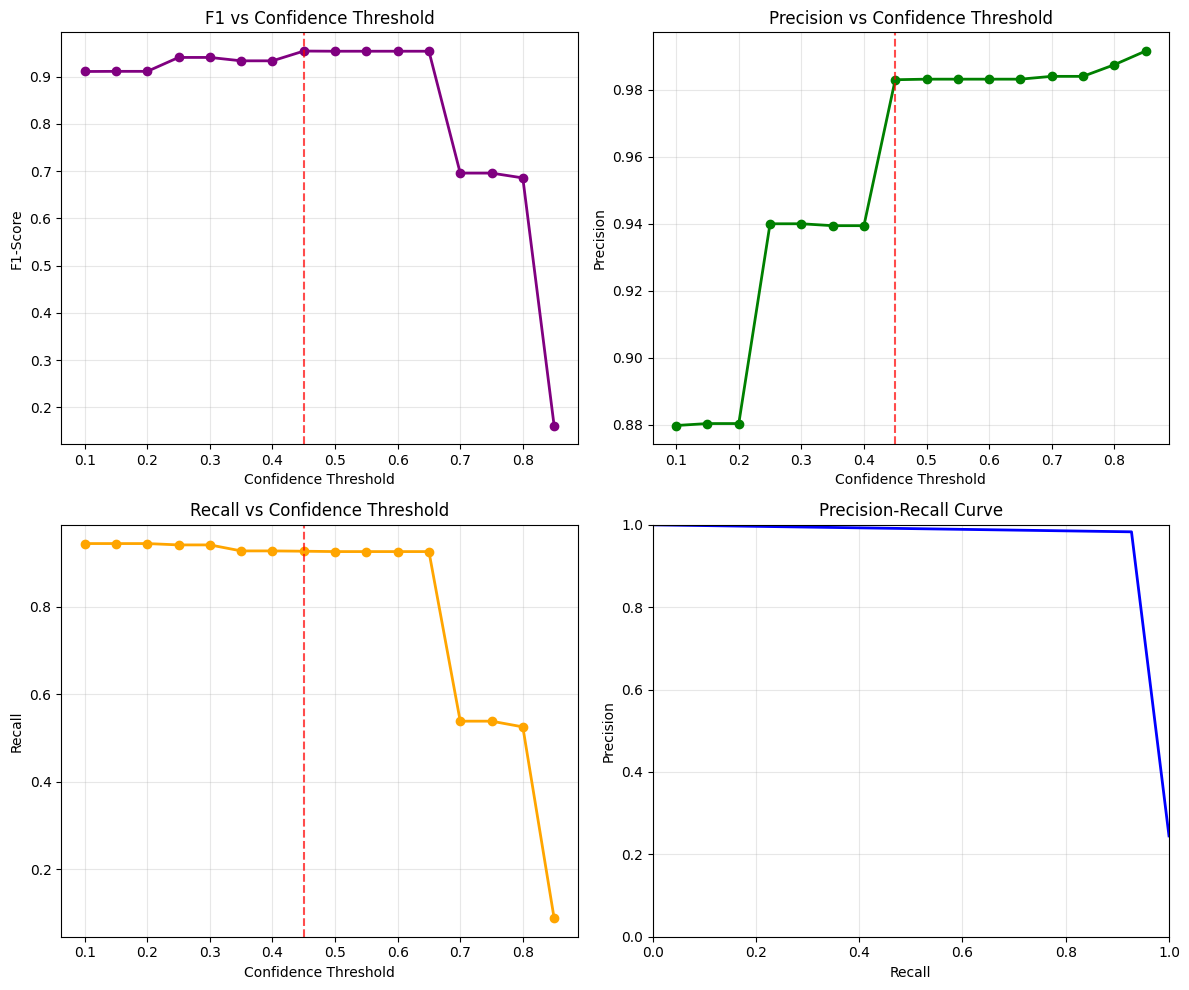

In [ ]:
# ====================
#  F1 & Metrics Curves
# ===================
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

def calculate_f1_at_thresholds(model, val_images, val_labels_dir, thresholds, num_images=15):
    """Calculate F1, precision, recall, accuracy at different confidence thresholds"""
    threshold_results = []
    all_pixels_data = {}  # Store pixel data for PR curve

    for threshold in thresholds:
        print(f"Testing threshold {threshold:.2f}...")
        all_gt_pixels = []
        all_pred_pixels = []

        for image_path in val_images[:num_images]:
            # Load image
            image = cv2.imread(image_path)
            if image is None:
                continue
            height, width = image.shape[:2]

            # Ground truth mask
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            label_path = os.path.join(val_labels_dir, f"{image_name}.txt")

            gt_mask = np.zeros((height, width), dtype=np.uint8)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 6:
                            seg_points = [float(x) for x in parts[5:]]
                            person_mask = convert_yolo_seg_to_mask(seg_points, width, height)
                            gt_mask = np.logical_or(gt_mask, person_mask)

            # Predicted mask at current threshold
            results = model(image_path, conf=threshold, verbose=False)
            pred_mask = np.zeros((height, width), dtype=np.uint8)

            if len(results) > 0 and results[0].masks is not None:
                for mask_data in results[0].masks.data:
                    mask_resized = cv2.resize(mask_data.cpu().numpy(), (width, height), interpolation=cv2.INTER_NEAREST)
                    pred_mask = np.logical_or(pred_mask, mask_resized > 0.5)

            # Flatten and accumulate
            all_gt_pixels.extend(gt_mask.flatten())
            all_pred_pixels.extend(pred_mask.flatten())

        if len(all_gt_pixels) > 0:
            precision_val = precision_score(all_gt_pixels, all_pred_pixels, average='binary', zero_division=0)
            recall_val = recall_score(all_gt_pixels, all_pred_pixels, average='binary', zero_division=0)
            f1_val = f1_score(all_gt_pixels, all_pred_pixels, average='binary', zero_division=0)

            threshold_results.append({
                'threshold': threshold,
                'precision': precision_val,
                'recall': recall_val,
                'f1': f1_val
            })

            # Store pixel data for the best threshold (for PR curve)
            if threshold == best_threshold:
                all_pixels_data['gt'] = all_gt_pixels
                all_pixels_data['pred'] = all_pred_pixels

    return threshold_results, all_pixels_data

# =====================
# Run threshold evaluation
# =====================
thresholds_to_test = np.arange(0.1, 0.9, 0.05)
print(f"Testing {len(thresholds_to_test)} thresholds...")
threshold_results, pixel_data = calculate_f1_at_thresholds(model, val_images, val_labels_dir, thresholds_to_test)

threshold_df = pd.DataFrame(threshold_results)
best_row = threshold_df.loc[threshold_df['f1'].idxmax()]
best_threshold = best_row['threshold']
best_f1 = best_row['f1']
print(f"Optimal Confidence Threshold: {best_threshold:.3f}, Best F1: {best_f1:.3f}")

# =====================
# Plot the four standard curves
# =====================
plt.figure(figsize=(12, 10))

# 1. F1 vs Threshold
plt.subplot(2, 2, 1)
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'purple', marker='o', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Confidence Threshold')
plt.ylabel('F1-Score')
plt.title('F1 vs Confidence Threshold')
plt.grid(True, alpha=0.3)

# 2. Precision vs Threshold
plt.subplot(2, 2, 2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'green', marker='o', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Confidence Threshold')
plt.grid(True, alpha=0.3)

# 3. Recall vs Threshold
plt.subplot(2, 2, 3)
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'orange', marker='o', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Confidence Threshold')
plt.grid(True, alpha=0.3)

# 4. Precision-Recall Curve (FIXED)
plt.subplot(2, 2, 4)
if pixel_data and len(pixel_data['gt']) > 0:
    precision_vals, recall_vals, _ = precision_recall_curve(pixel_data['gt'], pixel_data['pred'])
    plt.plot(recall_vals, precision_vals, 'b-', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No pixel data available\nfor PR curve',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Precision-Recall Curve\n(Data Not Available)')

plt.tight_layout()
plt.show()

Processing 0/10 images for segmentation analysis...


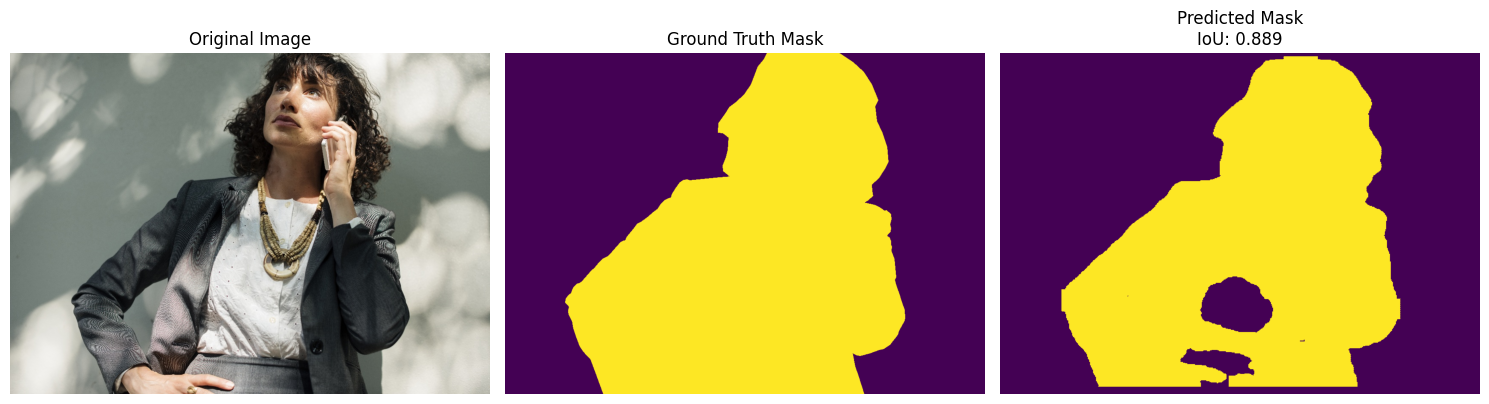

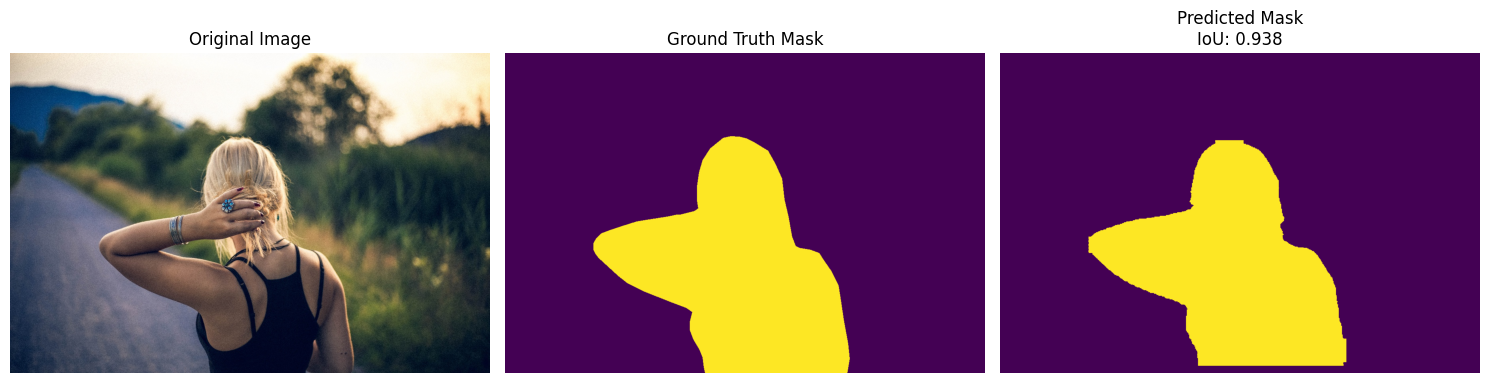

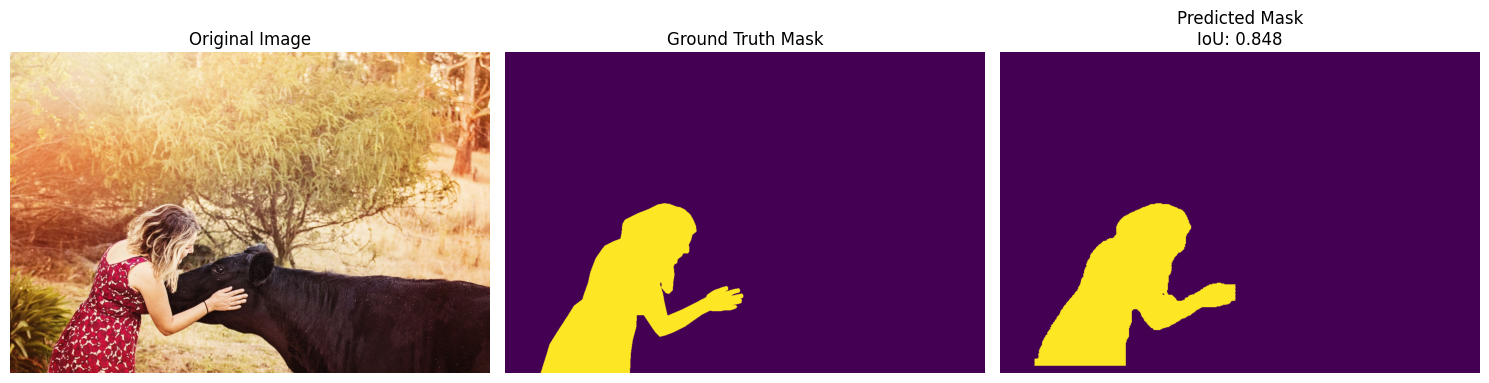

Processing 5/10 images for segmentation analysis...


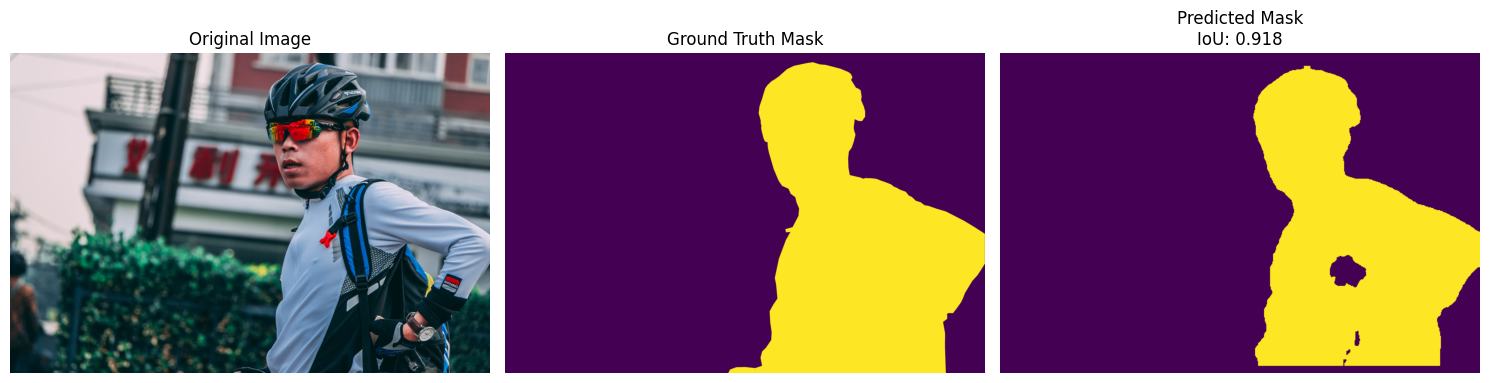

Average IoU: 0.792
IoU Std: 0.275
Min IoU: 0.000
Max IoU: 0.947
Images with IoU > 0.7: 8/10


In [ ]:
from ultralytics import YOLO

base_output_dir = r"C:\path\to\your\dataset"  # <-- change to your dataset folder
train_run = r"C:\Users\timot\runs\segment\train11"  # <-- your YOLO run folder
weights_path = os.path.join(train_run, "weights", "best.pt")

# Load trained YOLOv8 segmentation model
model = YOLO(weights_path)

# Directories for TEST set
test_images_dir = os.path.join(base_output_dir, "images", "test")
test_labels_dir = os.path.join(base_output_dir, "labels", "test")

# ----------------- FUNCTIONS -----------------
def convert_yolo_seg_to_mask(seg_points, image_width, image_height):
    """Convert YOLO segmentation points to binary mask"""
    points = []
    for i in range(0, len(seg_points), 2):
        if i + 1 < len(seg_points):
            x = seg_points[i] * image_width
            y = seg_points[i + 1] * image_height
            points.append([x, y])
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    if len(points) > 2:
        pts = np.array(points, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask

# ----------------- ANALYSIS -----------------
iou_scores = []
samples_to_show = []  # store sample data for visualization later
test_images = glob.glob(os.path.join(test_images_dir, "*"))

print(f"Found {len(test_images)} test images. Starting segmentation analysis...\n")

for i, image_path in enumerate(test_images, start=1):
    if i % 20 == 0:
        print(f"Processed {i}/{len(test_images)} images...")

    image = cv2.imread(image_path)
    if image is None:
        continue
    height, width = image.shape[:2]

    # ---- Ground Truth Mask ----
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(test_labels_dir, f"{image_name}.txt")

    gt_mask = np.zeros((height, width), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 6:
                    seg_points = [float(x) for x in parts[5:]]
                    person_mask = convert_yolo_seg_to_mask(seg_points, width, height)
                    gt_mask = np.logical_or(gt_mask, person_mask)

    # ---- Predicted Mask ----
    results = model(image_path, conf=0.45, verbose=False)
    pred_mask = np.zeros((height, width), dtype=np.uint8)

    if len(results) > 0 and results[0].masks is not None:
        for mask_data in results[0].masks.data:
            mask_resized = cv2.resize(mask_data.cpu().numpy(), (width, height))
            pred_mask = np.logical_or(pred_mask, mask_resized > 0.5)

    # ---- IoU Calculation ----
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    iou = intersection / union if union > 0 else 0
    iou_scores.append(iou)

    # Store up to 5 samples spaced throughout dataset
    if len(samples_to_show) < 5 and (i % (len(test_images) // 5 + 1) == 0 or len(test_images) <= 5):
        samples_to_show.append((image, gt_mask, pred_mask, iou))

# ----------------- VISUALIZATION -----------------
for idx, (image, gt_mask, pred_mask, iou) in enumerate(samples_to_show, start=1):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(gt_mask, cmap='viridis')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap='viridis')
    axes[2].set_title(f'Predicted Mask\nIoU: {iou:.3f}')
    axes[2].axis('off')

    plt.suptitle(f"Sample {idx}/{len(samples_to_show)}", fontsize=14)
    plt.tight_layout()
    plt.show()

# ----------------- SUMMARY -----------------
  print(f"\n==== Segmentation Quality (TEST set) ====")
  print(f"Average IoU: {np.mean(iou_scores):.3f}")
  print(f"IoU Std: {np.std(iou_scores):.3f}")
  print(f"Min IoU: {np.min(iou_scores):.3f}")
  print(f"Max IoU: {np.max(iou_scores):.3f}")
  print(f"Images with IoU > 0.7: {sum(iou > 0.7 for iou in iou_scores)}/{len(iou_scores)}")

Testing on new internet images...

Testing image 1/10: https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba
✅ Detections: 1
   - person: confidence 0.736


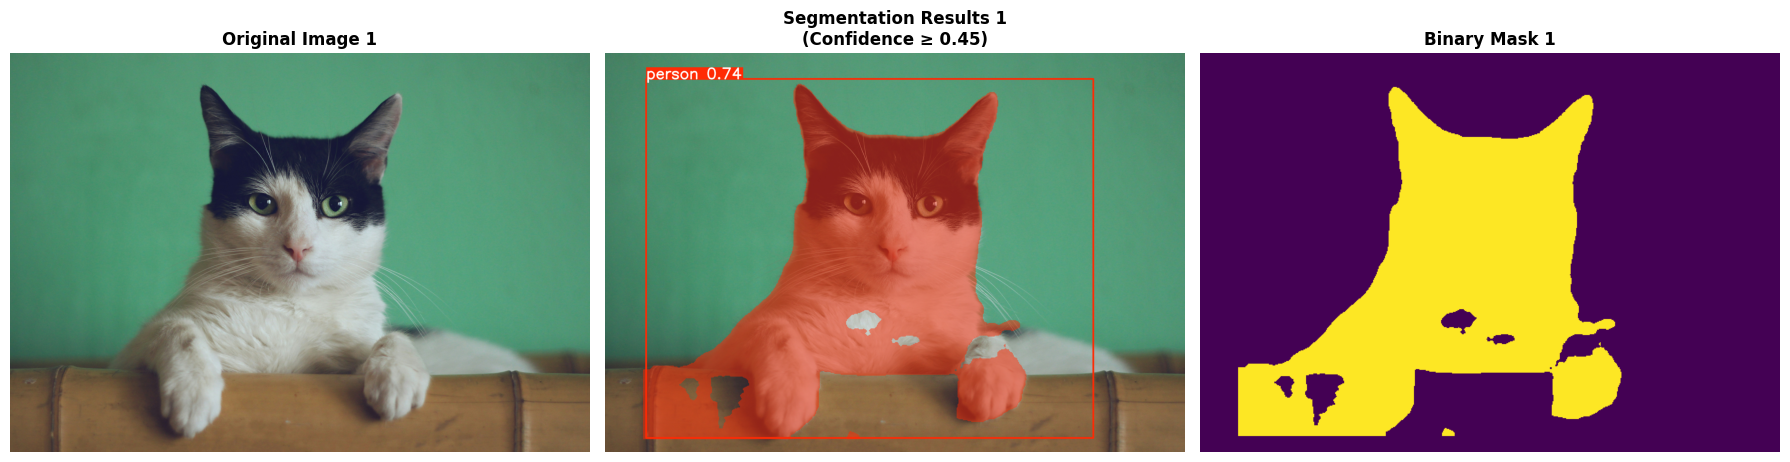


Testing image 2/10: https://images.pexels.com/photos/1079791/pexels-photo-1079791.jpeg
✅ Detections: 1
   - person: confidence 0.913


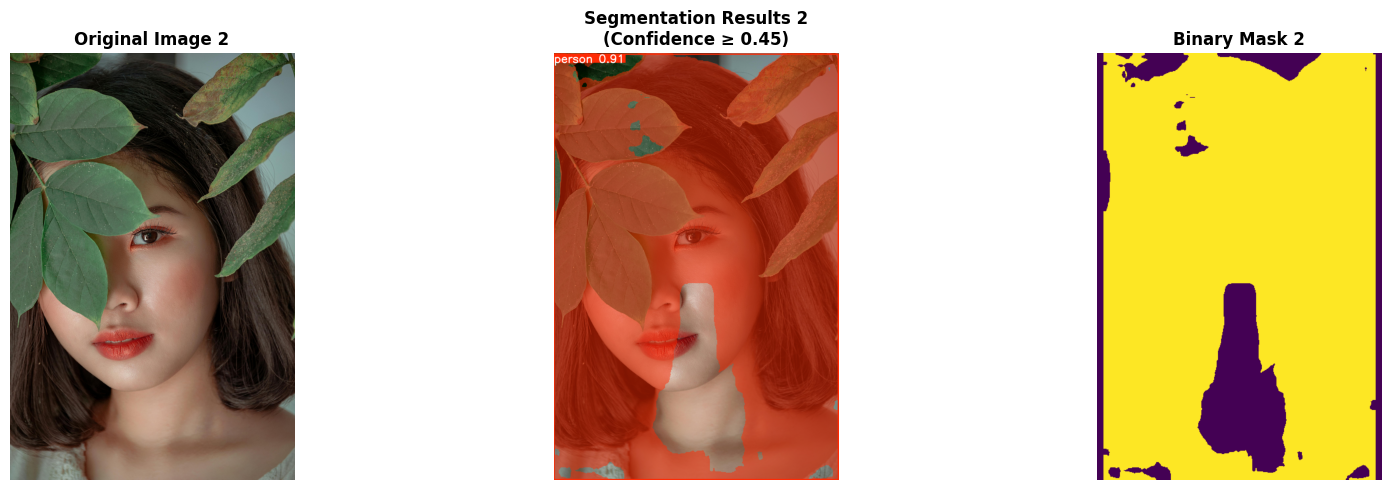


Testing image 3/10: https://images.pexels.com/photos/4596636/pexels-photo-4596636.jpeg
✅ Detections: 1
   - person: confidence 0.675


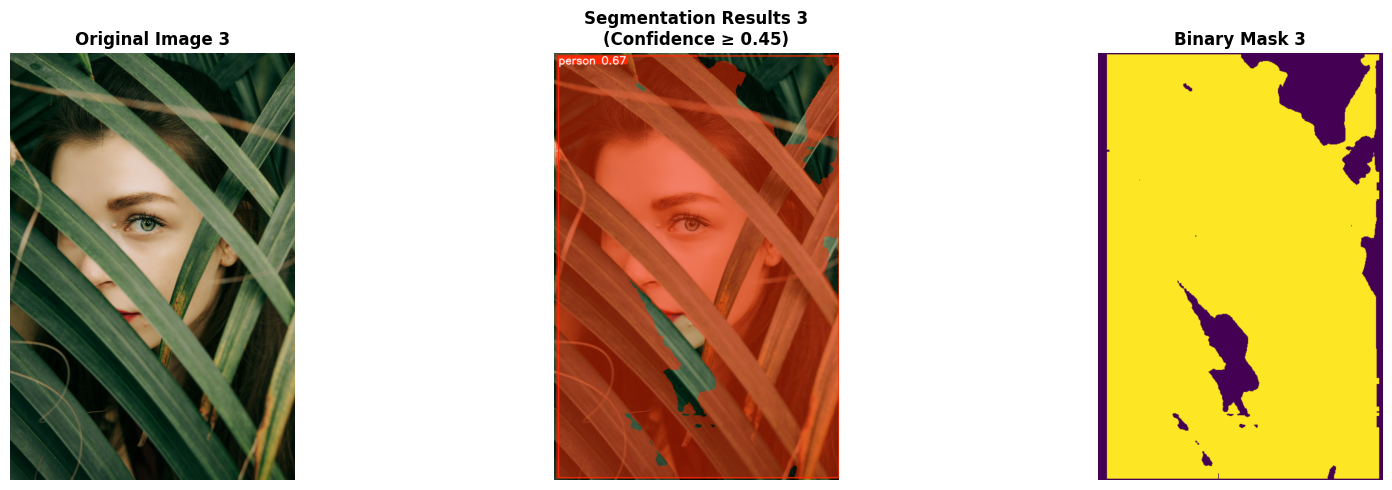


Testing image 4/10: https://images.pexels.com/photos/1848471/pexels-photo-1848471.jpeg
✅ Detections: 1
   - person: confidence 0.775


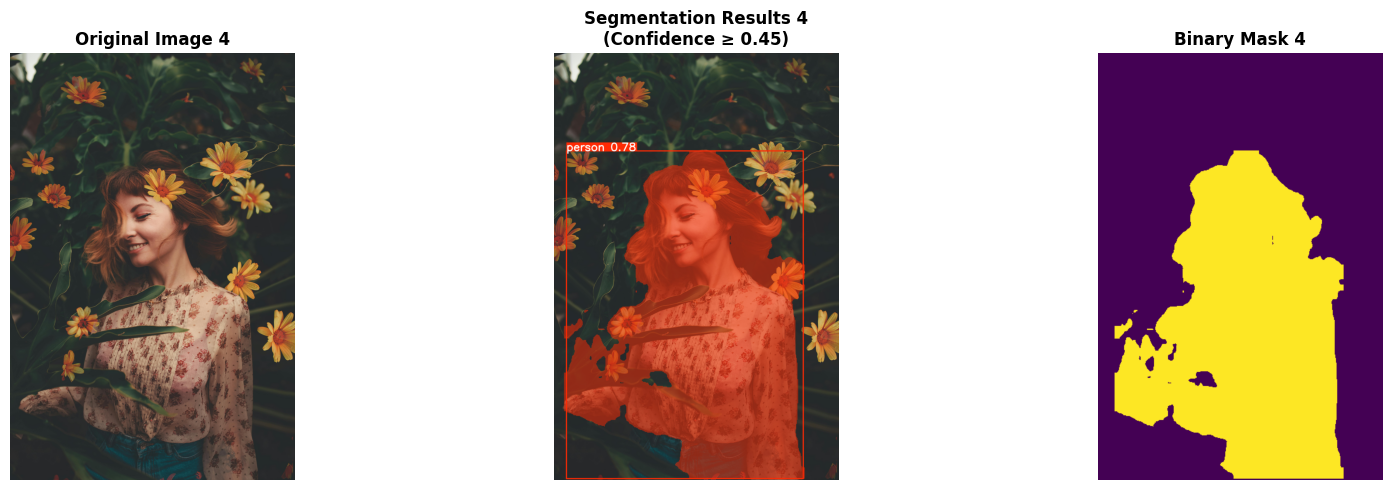


Testing image 5/10: https://images.pexels.com/photos/1681010/pexels-photo-1681010.jpeg
✅ Detections: 1
   - person: confidence 0.941


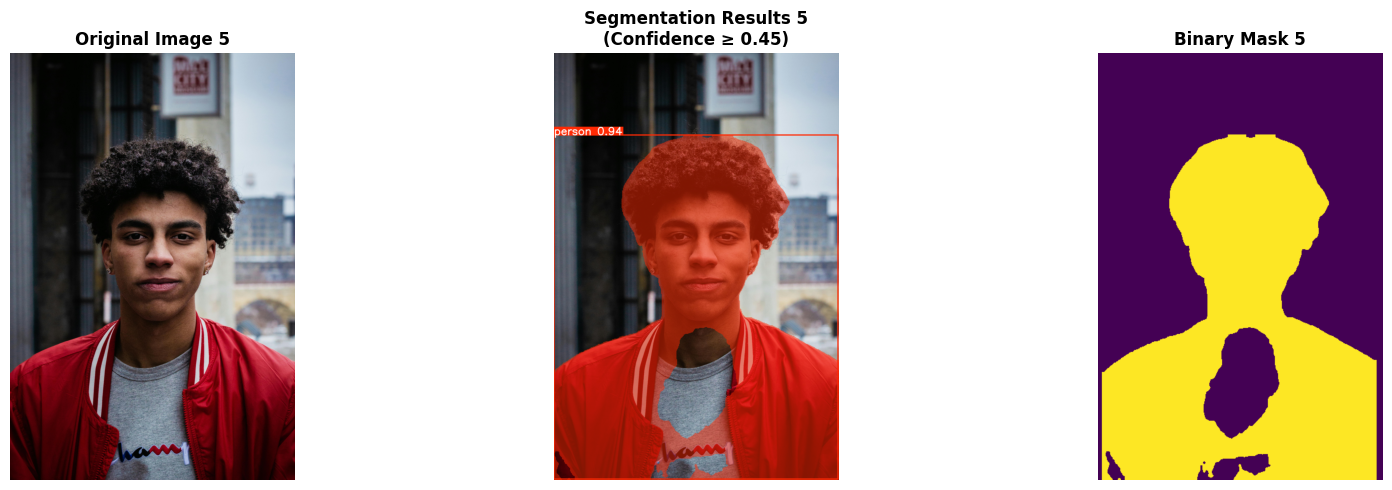


Testing image 6/10: https://images.pexels.com/photos/1006195/pexels-photo-1006195.png
✅ Detections: 1
   - person: confidence 0.940


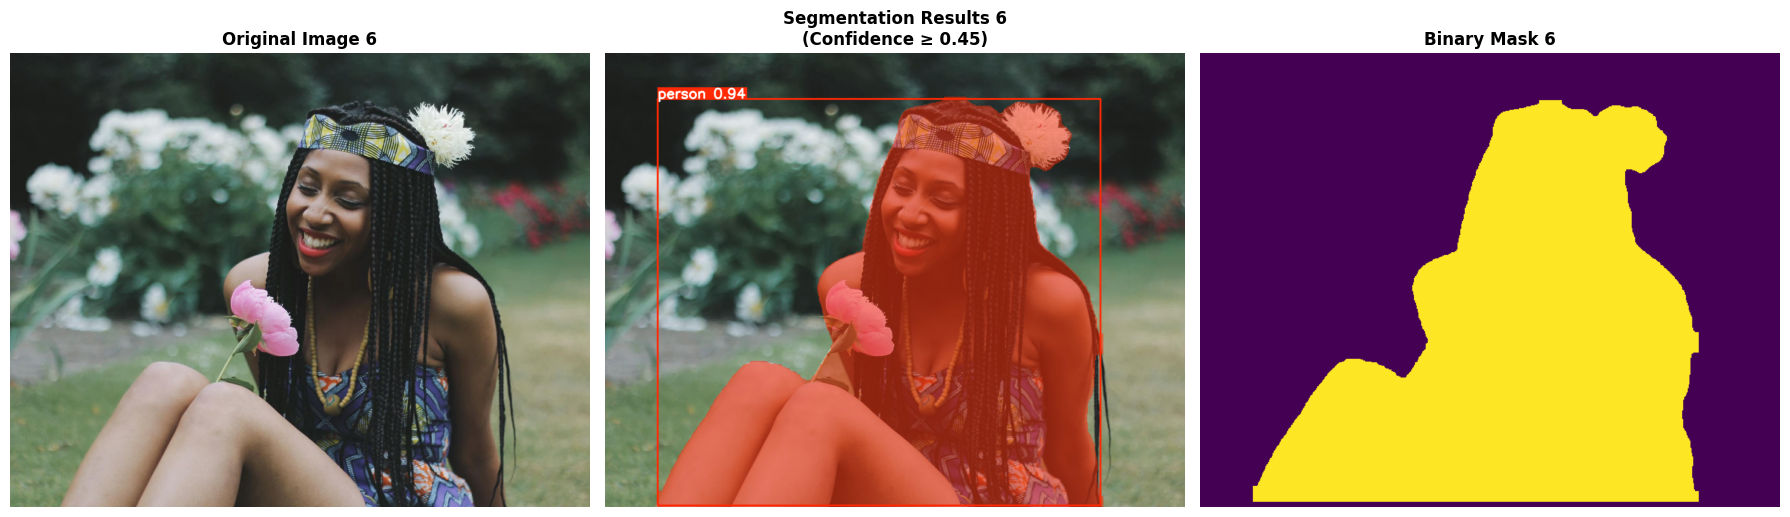


Testing image 7/10: https://images.pexels.com/photos/10306062/pexels-photo-10306062.jpeg
✅ Detections: 1
   - person: confidence 0.839


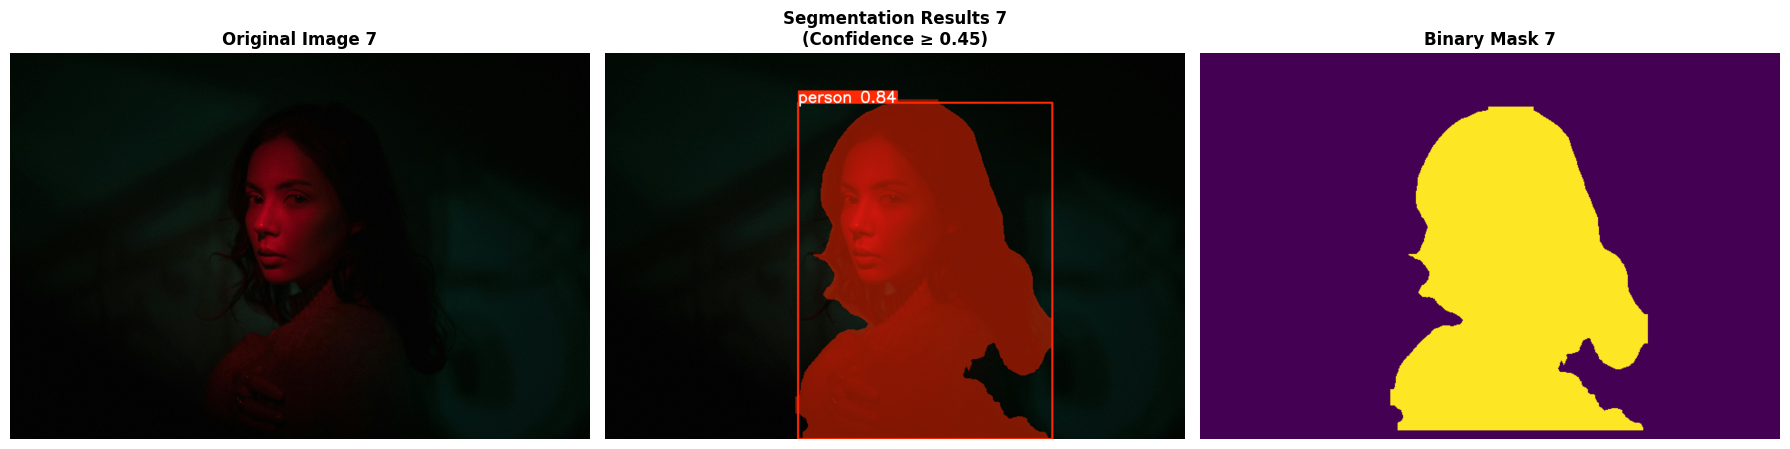


Testing image 8/10: https://images.pexels.com/photos/8920166/pexels-photo-8920166.jpeg
✅ Detections: 1
   - person: confidence 0.914


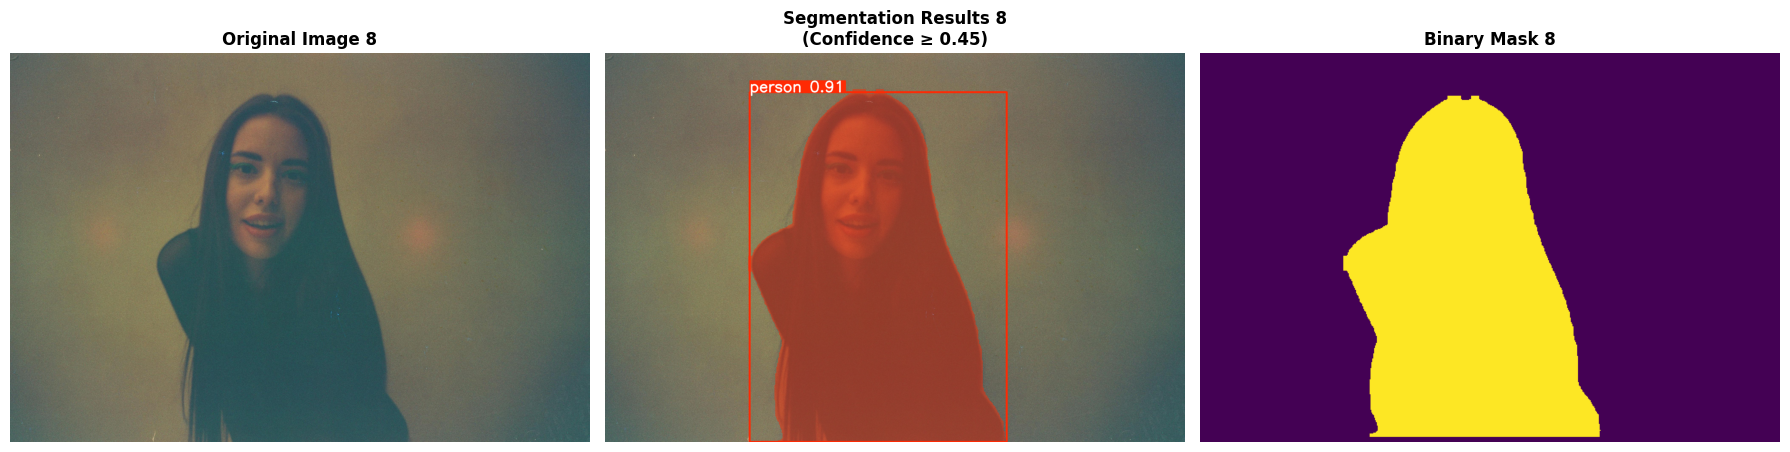


Testing image 9/10: https://images.pexels.com/photos/34384807/pexels-photo-34384807.jpeg
❌ No detections


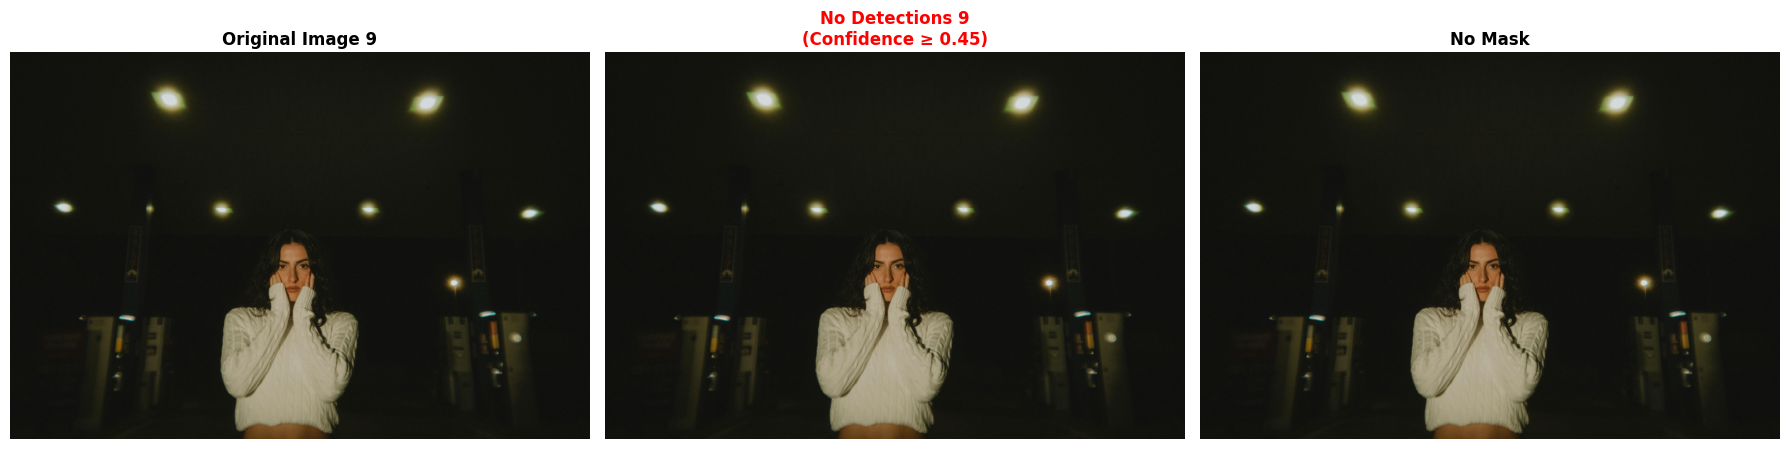


Testing image 10/10: https://images.pexels.com/photos/15169310/pexels-photo-15169310.jpeg
❌ No detections


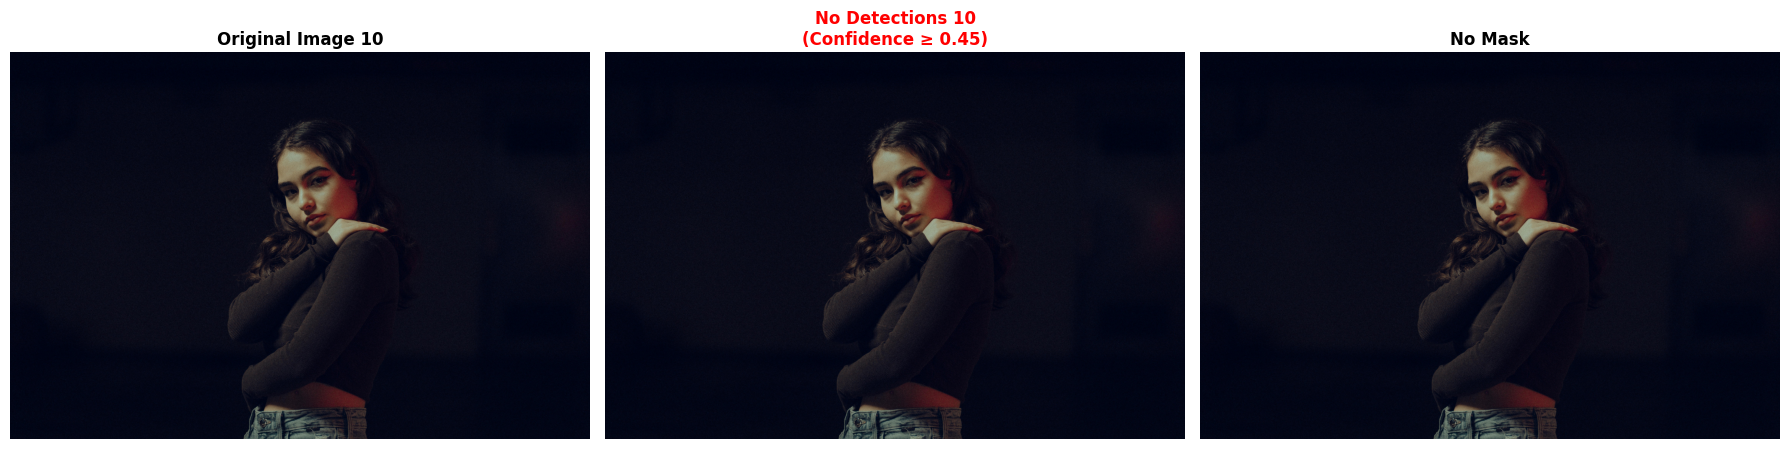


✅ INTERNET IMAGE TESTING COMPLETED!


In [ ]:
# =====================
# Test on New Internet Images
# =====================

import requests
from PIL import Image
import urllib.parse

# Your test images
test_urls = [
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba",  # Cat (negative test)
    "https://images.pexels.com/photos/1079791/pexels-photo-1079791.jpeg",  # Person
    "https://images.pexels.com/photos/4596636/pexels-photo-4596636.jpeg",  # Person
    "https://images.pexels.com/photos/1848471/pexels-photo-1848471.jpeg",  # Person
    "https://images.pexels.com/photos/1681010/pexels-photo-1681010.jpeg",  # Person
    "https://images.pexels.com/photos/1006195/pexels-photo-1006195.png",   # Person
    "https://images.pexels.com/photos/10306062/pexels-photo-10306062.jpeg", # Person
    "https://images.pexels.com/photos/8920166/pexels-photo-8920166.jpeg",   # Person
    "https://images.pexels.com/photos/34384807/pexels-photo-34384807.jpeg", # Person
    "https://images.pexels.com/photos/15169310/pexels-photo-15169310.jpeg"  # Person
]

# Load your best model
best_model_path = 'runs/segment/train7/weights/best.pt'  # Your current training
model = YOLO(best_model_path)

print("Testing on new internet images...")

for i, url in enumerate(test_urls):
    print(f"\nTesting image {i+1}/{len(test_urls)}: {url}")

    try:
        # Download image
        response = requests.get(url, stream=True)
        response.raise_for_status()

        # Open and convert image
        image = Image.open(response.raw).convert('RGB')
        image_np = np.array(image)

        # Run inference with your optimal confidence
        results = model(image_np, conf=0.45, verbose=False)  # Use your optimal threshold

        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Original image
        axes[0].imshow(image_np)
        axes[0].set_title(f'Original Image {i+1}', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Results with segmentation
        if len(results) > 0 and hasattr(results[0], 'plot') and results[0].masks is not None:
            # Plot results with segmentation masks
            plotted = results[0].plot()
            axes[1].imshow(plotted)
            axes[1].set_title(f'Segmentation Results {i+1}\n(Confidence ≥ 0.45)',
                            fontsize=12, fontweight='bold')
            axes[1].axis('off')

            # Just the binary mask
            height, width = image_np.shape[:2]
            pred_mask = np.zeros((height, width), dtype=np.uint8)

            for mask_data in results[0].masks.data:
                mask_resized = cv2.resize(mask_data.cpu().numpy(), (width, height),
                                        interpolation=cv2.INTER_NEAREST)
                pred_mask = np.logical_or(pred_mask, mask_resized > 0.5)

            axes[2].imshow(pred_mask, cmap='viridis')
            axes[2].set_title(f'Binary Mask {i+1}', fontsize=12, fontweight='bold')
            axes[2].axis('off')

            # Print detection info
            num_detections = len(results[0])
            print(f"Detections: {num_detections}")
            for j, (box, mask) in enumerate(zip(results[0].boxes, results[0].masks)):
                conf = box.conf.item()
                cls_id = int(box.cls.item())
                cls_name = model.names[cls_id]
                print(f"   - {cls_name}: confidence {conf:.3f}")

        else:
            # No detections
            axes[1].imshow(image_np)
            axes[1].set_title(f'No Detections {i+1}\n(Confidence ≥ 0.45)',
                            fontsize=12, fontweight='bold', color='red')
            axes[1].axis('off')

            axes[2].imshow(image_np)
            axes[2].set_title('No Mask', fontsize=12, fontweight='bold')
            axes[2].axis('off')

            print("No detections")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing image {i+1}: {e}")
        continue

Creating pixel-level confusion matrix...
Processing 0/10 images for pixel analysis...
Processing 5/10 images for pixel analysis...


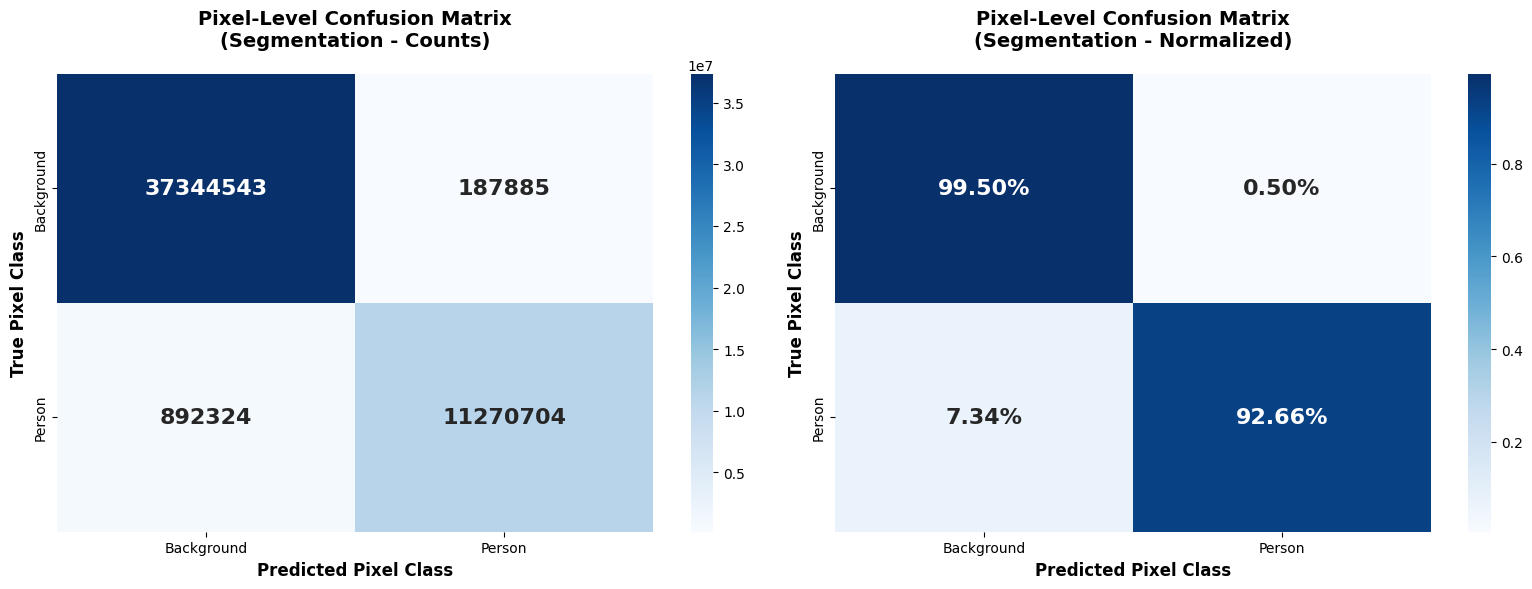

Metric       Score    Percentage  
----------------------------------------
Accuracy     0.9783     97.83%
Precision    0.9836     98.36%
Recall       0.9266     92.66%
F1-Score     0.9543     95.43%
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

  Background     0.9767    0.9950    0.9857  37532428
      Person     0.9836    0.9266    0.9543  12163028

    accuracy                         0.9783  49695456
   macro avg     0.9801    0.9608    0.9700  49695456
weighted avg     0.9784    0.9783    0.9780  49695456



In [ ]:
# =====================
# Confusion Matrix
# =====================
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def create_segmentation_confusion_matrix(model, val_images, val_labels_dir, num_images=20):
    """Create pixel-level confusion matrix for segmentation"""
    all_gt_pixels = []
    all_pred_pixels = []

    for i, image_path in enumerate(val_images[:num_images]):
        if i % 5 == 0:
            print(f"Processing {i}/{min(num_images, len(val_images))} images for pixel analysis...")

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            continue
        height, width = image.shape[:2]

        # Ground truth mask
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        label_path = os.path.join(val_labels_dir, f"{image_name}.txt")

        gt_mask = np.zeros((height, width), dtype=np.uint8)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 6:
                        seg_points = [float(x) for x in parts[5:]]
                        person_mask = convert_yolo_seg_to_mask(seg_points, width, height)
                        gt_mask = np.logical_or(gt_mask, person_mask)

        # Predicted mask
        results = model(image_path, conf=0.45, verbose=False)
        pred_mask = np.zeros((height, width), dtype=np.uint8)

        if len(results) > 0 and results[0].masks is not None:
            for mask_data in results[0].masks.data:
                mask_resized = cv2.resize(mask_data.cpu().numpy(), (width, height))
                pred_mask = np.logical_or(pred_mask, mask_resized > 0.5)

        # Flatten masks to 1D arrays for confusion matrix
        all_gt_pixels.extend(gt_mask.flatten())
        all_pred_pixels.extend(pred_mask.flatten())

    return np.array(all_gt_pixels), np.array(all_pred_pixels)

# Create pixel-level confusion matrix
print("Creating pixel-level confusion matrix...")
gt_pixels, pred_pixels = create_segmentation_confusion_matrix(
    model, val_images, val_labels_dir, num_images=30
)

# Calculate confusion matrix
cm = confusion_matrix(gt_pixels, pred_pixels)
cm_normalized = confusion_matrix(gt_pixels, pred_pixels, normalize='true')

labels = ['Background', 'Person']

# Create DataFrames
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_norm_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

# Plot confusion matrices
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Pixel-Level Confusion Matrix\n(Segmentation - Counts)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Pixel Class', fontsize=12, fontweight='bold')
plt.ylabel('True Pixel Class', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
sns.heatmap(cm_norm_df, annot=True, fmt='.2%', cmap='Blues', cbar=True,
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Pixel-Level Confusion Matrix\n(Segmentation - Normalized)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Pixel Class', fontsize=12, fontweight='bold')
plt.ylabel('True Pixel Class', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate metrics
accuracy = accuracy_score(gt_pixels, pred_pixels)
precision = precision_score(gt_pixels, pred_pixels, average='binary', zero_division=0)
recall = recall_score(gt_pixels, pred_pixels, average='binary', zero_division=0)
f1 = f1_score(gt_pixels, pred_pixels, average='binary', zero_division=0)

print(f"{'Metric':<12} {'Score':<8} {'Percentage':<12}")
print("-" * 40)
print(f"{'Accuracy':<12} {accuracy:.4f}    {accuracy*100:>6.2f}%")
print(f"{'Precision':<12} {precision:.4f}    {precision*100:>6.2f}%")
print(f"{'Recall':<12} {recall:.4f}    {recall*100:>6.2f}%")
print(f"{'F1-Score':<12} {f1:.4f}    {f1*100:>6.2f}%")
print("-" * 40)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(gt_pixels, pred_pixels, target_names=labels, digits=4))